In [1]:
%matplotlib inline
import os 
import theano
from theano import tensor as T
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

In [2]:
""" What does the softmax learn? """
def analyze_net(w_o, img_dim):    
    matplotlib.rc('xtick', labelsize=30) 
    matplotlib.rc('ytick', labelsize=30)   

    a = np.array(w_o.get_value())  
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(40, 15))
    for i, ax in enumerate(axes.flat):
        ax.set_title(str(i), fontsize=50)
        im = ax.imshow(a[:,i].reshape(img_dim, img_dim), interpolation='none')

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    plt.show()
    #plt.pause(0.1)
    
def one_hot(x, n):
    if type(x) == list:
        x = np.array(x)       
    x = x.flatten()
    o_h = np.zeros((len(x), n))
    o_h[np.arange(len(x)), x] = 1
    return o_h

def mnist(ntrain=60000, ntest=10000, onehot=True):
    """
    Load and devide MNIST data set into train, test sets
    X is image, and Y is its label.
    The image size is 28*28, and we flatten it to a 784-dim vector
    
    The label is represented in onehot vector. A onehot vector is 
    a vector which is 0 in most dimensions, and 1 in a single 
    dimension. In this case, the nth digit will be represented as 
    a vector which is 1 in the nth dimensions. 
    For example, 0 would be [1,0,0,0,0,0,0,0,0,0,0]. 
    """
    
    data_dir = 'datasets\\mnist'
    
    fd = open(os.path.join(data_dir, 'train-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    trX = loaded[16:].reshape((60000, 28*28)).astype(float)

    fd = open(os.path.join(data_dir, 'train-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    trY = loaded[8:].reshape((60000))

    fd = open(os.path.join(data_dir, 't10k-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    teX = loaded[16:].reshape((10000, 28*28)).astype(float)

    fd = open(os.path.join(data_dir, 't10k-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    teY = loaded[8:].reshape((10000))

    trX = trX/255.
    teX = teX/255.

    trX = trX[:ntrain]
    trY = trY[:ntrain]

    teX = teX[:ntest]
    teY = teY[:ntest]
    
    if onehot:
        trY = one_hot(trY, 10)
        teY = one_hot(teY, 10)
    else:
        trY = np.asarray(trY)
        teY = np.asarray(teY)

    return trX,teX,trY,teY

trX, teX, trY, teY = mnist(onehot=True)  #Loading data matrices

In [19]:
def floatX(X):
    """ Conver to correct dtype """
    return np.asarray(X, dtype=theano.config.floatX)

def init_weights(shape):
    """ initalize model parameters """
    return theano.shared(floatX(np.random.randn(*shape) * 0.01))

def model(X, w):
    """Logistic regresion in matrix format y = softmax(X.w)
    This neural net has no hidden layer.
    """
    return T.nnet.softmax(T.dot(X, w))


In [20]:
X = T.fmatrix()  # matrix types variables
Y = T.fmatrix()

w = init_weights((784, 10))  # initalize weights matrix

In [21]:
py_x = model(X, w)  # p(y|x): probability of label given the input
y_pred = T.argmax(py_x, axis=1)  # probality outputs and max predictions

In [22]:
"""
In order to train our model, we need to define what it means for the model 
to be good. Well, actually, in machine learning we typically define what it 
means for a model to be bad, called the cost or loss, and then try to minimize 
how bad it is. But the two are equivalent.

One very common, very nice cost function is "cross-entropy." Surprisingly, 
cross-entropy arises from thinking about information compressing codes in 
information theory but it winds up being an important idea in lots of areas, 
from gambling to machine learning. It's defined:

              H_Y(py_x) = - \sum_i y_i * log(py_x_i)
              
where Y os the true distribution (the one-hot vector we'll input)
py_x is our predicted probability distribution
In some rough sense, the cross-entropy is measuring how inefficient our 
predictions are for describing the truth.   

"""
cost = T.mean(T.nnet.categorical_crossentropy(py_x, Y))

In [23]:
gradient = T.grad(cost=cost, wrt=w)  # Compute gradient
update = [[w, w - gradient * 0.05]]  # Weight update with gradient descent

# compile train function
train = theano.function(inputs=[X, Y], outputs=cost, updates=update, allow_input_downcast=True)

# compile prediction function
predict = theano.function(inputs=[X], outputs=y_pred, allow_input_downcast=True)

In [25]:
# run training with 100 iteration and on mini-batches of 128 examples
for i in range(100):
    for start, end in zip(range(0, len(trX), 128), range(128, len(trX), 128)):
        cost = train(trX[start:end], trY[start:end])
    print i, np.mean(np.argmax(teY, axis=1) == predict(teX))
        

0 0.9231
1 0.9233
2 0.9237
3 0.9237
4 0.9236
5 0.9238
6 0.9236
7 0.9236
8 0.9237
9 0.9239
10 0.924
11 0.924
12 0.924
13 0.9241
14 0.9241
15 0.9241
16 0.9242
17 0.9244
18 0.9242
19 0.9243
20 0.9244
21 0.9245
22 0.9246
23 0.9246
24 0.9246
25 0.9244
26 0.9244
27 0.9244
28 0.9245
29 0.9244
30 0.9244
31 0.9244
32 0.9244
33 0.9245
34 0.9246
35 0.9245
36 0.9245
37 0.9247
38 0.9246
39 0.9246
40 0.9246
41 0.9247
42 0.9248
43 0.9248
44 0.9248
45 0.925
46 0.925
47 0.925
48 0.925
49 0.925
50 0.9249
51 0.9249
52 0.9248
53 0.9248
54 0.9247
55 0.9246
56 0.9245
57 0.9246
58 0.9245
59 0.9244
60 0.9244
61 0.9244
62 0.9244
63 0.9244
64 0.9244
65 0.9244
66 0.9244
67 0.9247
68 0.9247
69 0.9246
70 0.9246
71 0.9247
72 0.9246
73 0.9247
74 0.9246
75 0.9246
76 0.9246
77 0.9247
78 0.9249
79 0.925
80 0.925
81 0.9252
82 0.9252
83 0.9252
84 0.9252
85 0.9251
86 0.9251
87 0.9249
88 0.9249
89 0.9249
90 0.9248
91 0.9248
92 0.9248
93 0.9248
94 0.9249
95 0.925
96 0.9249
97 0.9251
98 0.9251
99 0.9251


Softmax [@A] ''   
 |dot [@B] ''   
   |<TensorType(float32, matrix)> [@C]
   |<TensorType(float64, matrix)> [@D]


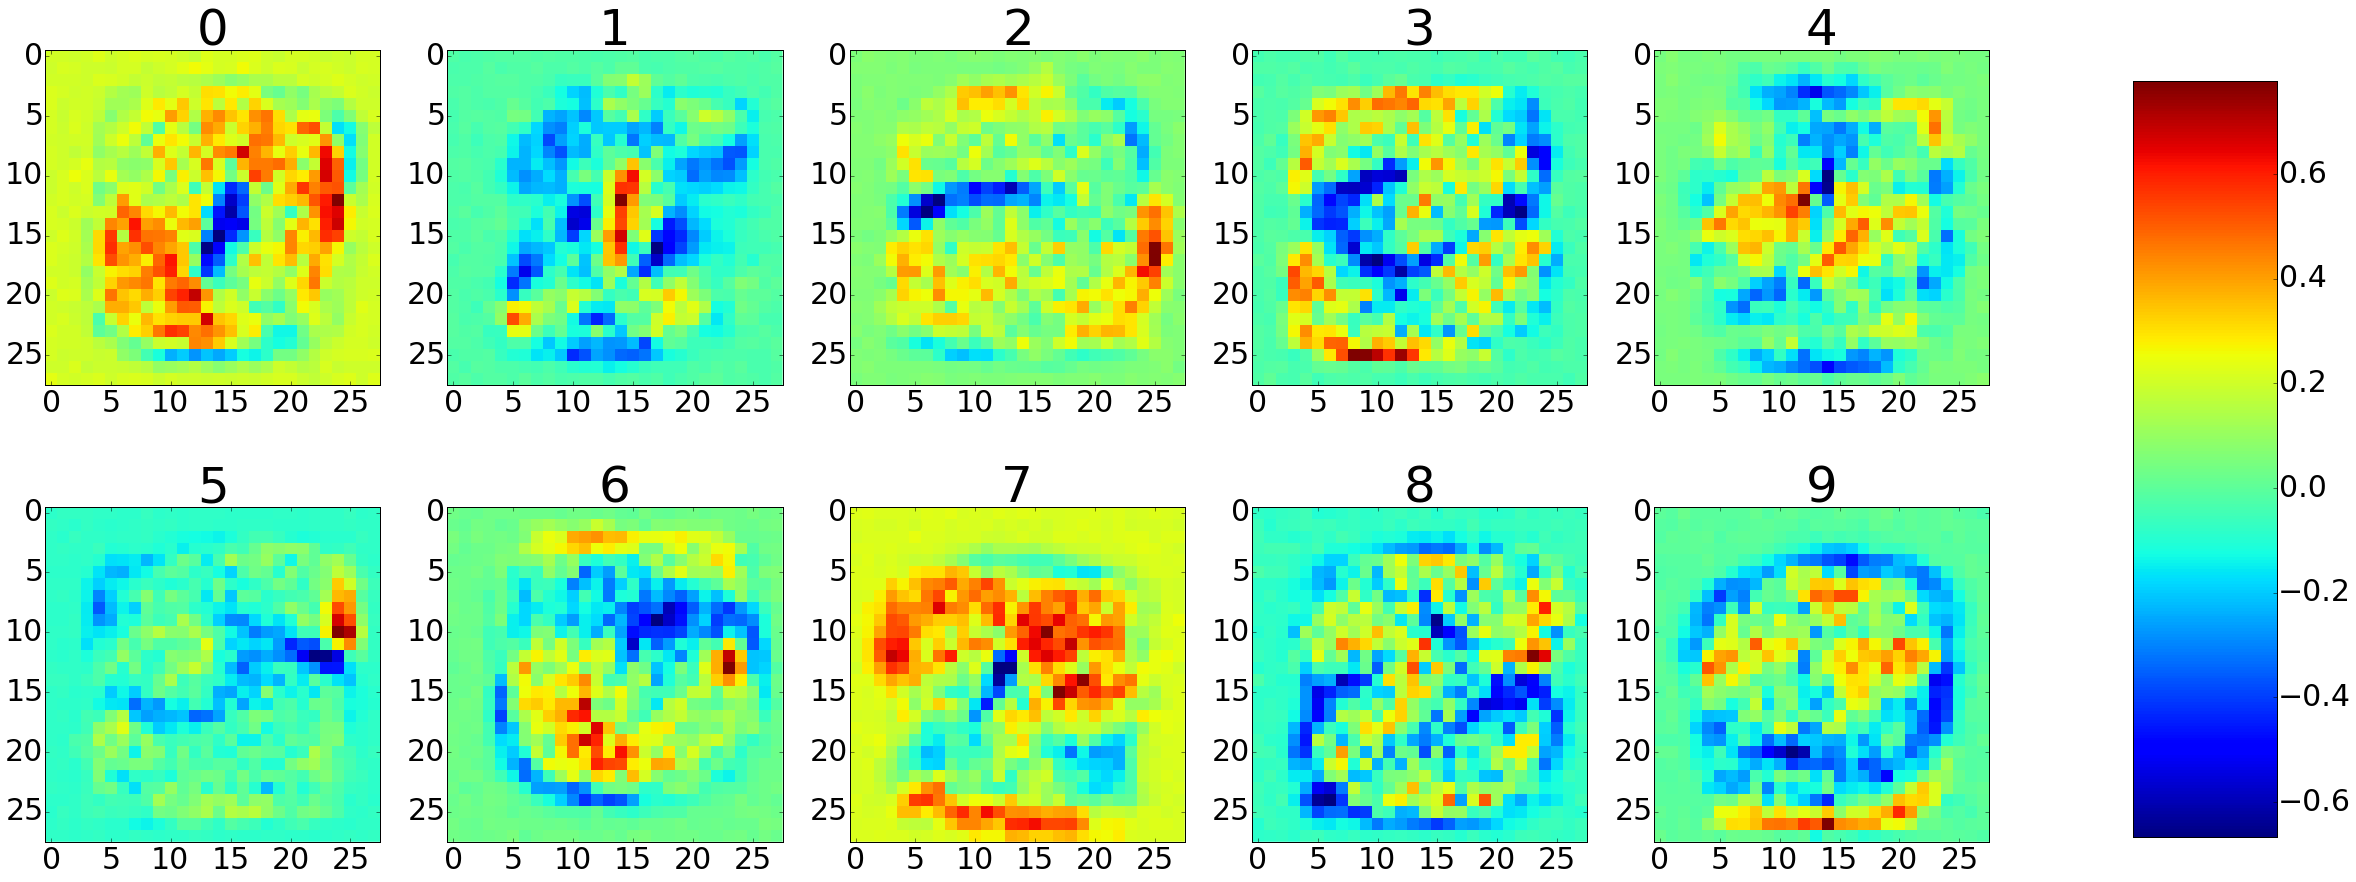

In [26]:
""" What does the softmax learn? """
theano.printing.debugprint(py_x)
analyze_net(w, 28)

In [27]:
""" A feed forward neural network with 1 hidden layer
The NN architecture is 784 -> 635 -> 10
We change model() and use Schotastic Gradient Descent to update weight()
"""

def sgd(cost, params, lr=0.05):
    """generalize to compute gradien descent on all model parameters"""
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        updates.append([p, p - g * lr])
    return updates

def model(X, w_h, w_o):
    # hidden layer use sigmod as its activation function
    h = T.nnet.sigmoid(T.dot(X, w_h))
        
    #output layer still uses softmax
    pyx = T.nnet.softmax(T.dot(h, w_o))
    return pyx


In [28]:
w_h = init_weights((784, 625))  # initialize weights for hidden layer
w_o = init_weights((625, 10))

py_x = model(X, w_h, w_o)
y_x = T.argmax(py_x, axis=1)

cost = T.mean(T.nnet.categorical_crossentropy(py_x, Y))
params = [w_h, w_o]  # the NN has 1 hidden layer and 1 output layer
updates = sgd(cost, params) # use SGD as it update function

train = theano.function(inputs=[X, Y], outputs=cost, updates=updates, allow_input_downcast=True)
predict = theano.function(inputs=[X], outputs=y_x, allow_input_downcast=True)

matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30)

for i in range(50):
    for start, end in zip(range(0, len(trX), 128), range(128, len(trX), 128)):
        cost = train(trX[start:end], trY[start:end])
    print i, np.mean(np.argmax(teY, axis=1) == predict(teX))          

0 0.7005
1 0.8283
2 0.8667
3 0.8827
4 0.8898
5 0.8949
6 0.8993
7 0.9018
8 0.9046
9 0.9066
10 0.9089
11 0.9114
12 0.9124
13 0.9134
14 0.9153
15 0.9158
16 0.9167
17 0.9172
18 0.9183
19 0.9188
20 0.9191
21 0.9191
22 0.9196
23 0.9201
24 0.9208
25 0.9214
26 0.9214
27 0.9224
28 0.9225
29 0.9233
30 0.9237
31 0.9239
32 0.9245
33 0.9251
34 0.9263
35 0.9265
36 0.9268
37 0.9276
38 0.9281
39 0.9286
40 0.9294
41 0.9298
42 0.9304
43 0.9314
44 0.9319
45 0.9328
46 0.9333
47 0.9337
48 0.9346
49 0.935


Softmax [@A] ''   
 |dot [@B] ''   
   |sigmoid [@C] ''   
   | |dot [@D] ''   
   |   |<TensorType(float32, matrix)> [@E]
   |   |<TensorType(float64, matrix)> [@F]
   |<TensorType(float64, matrix)> [@G]


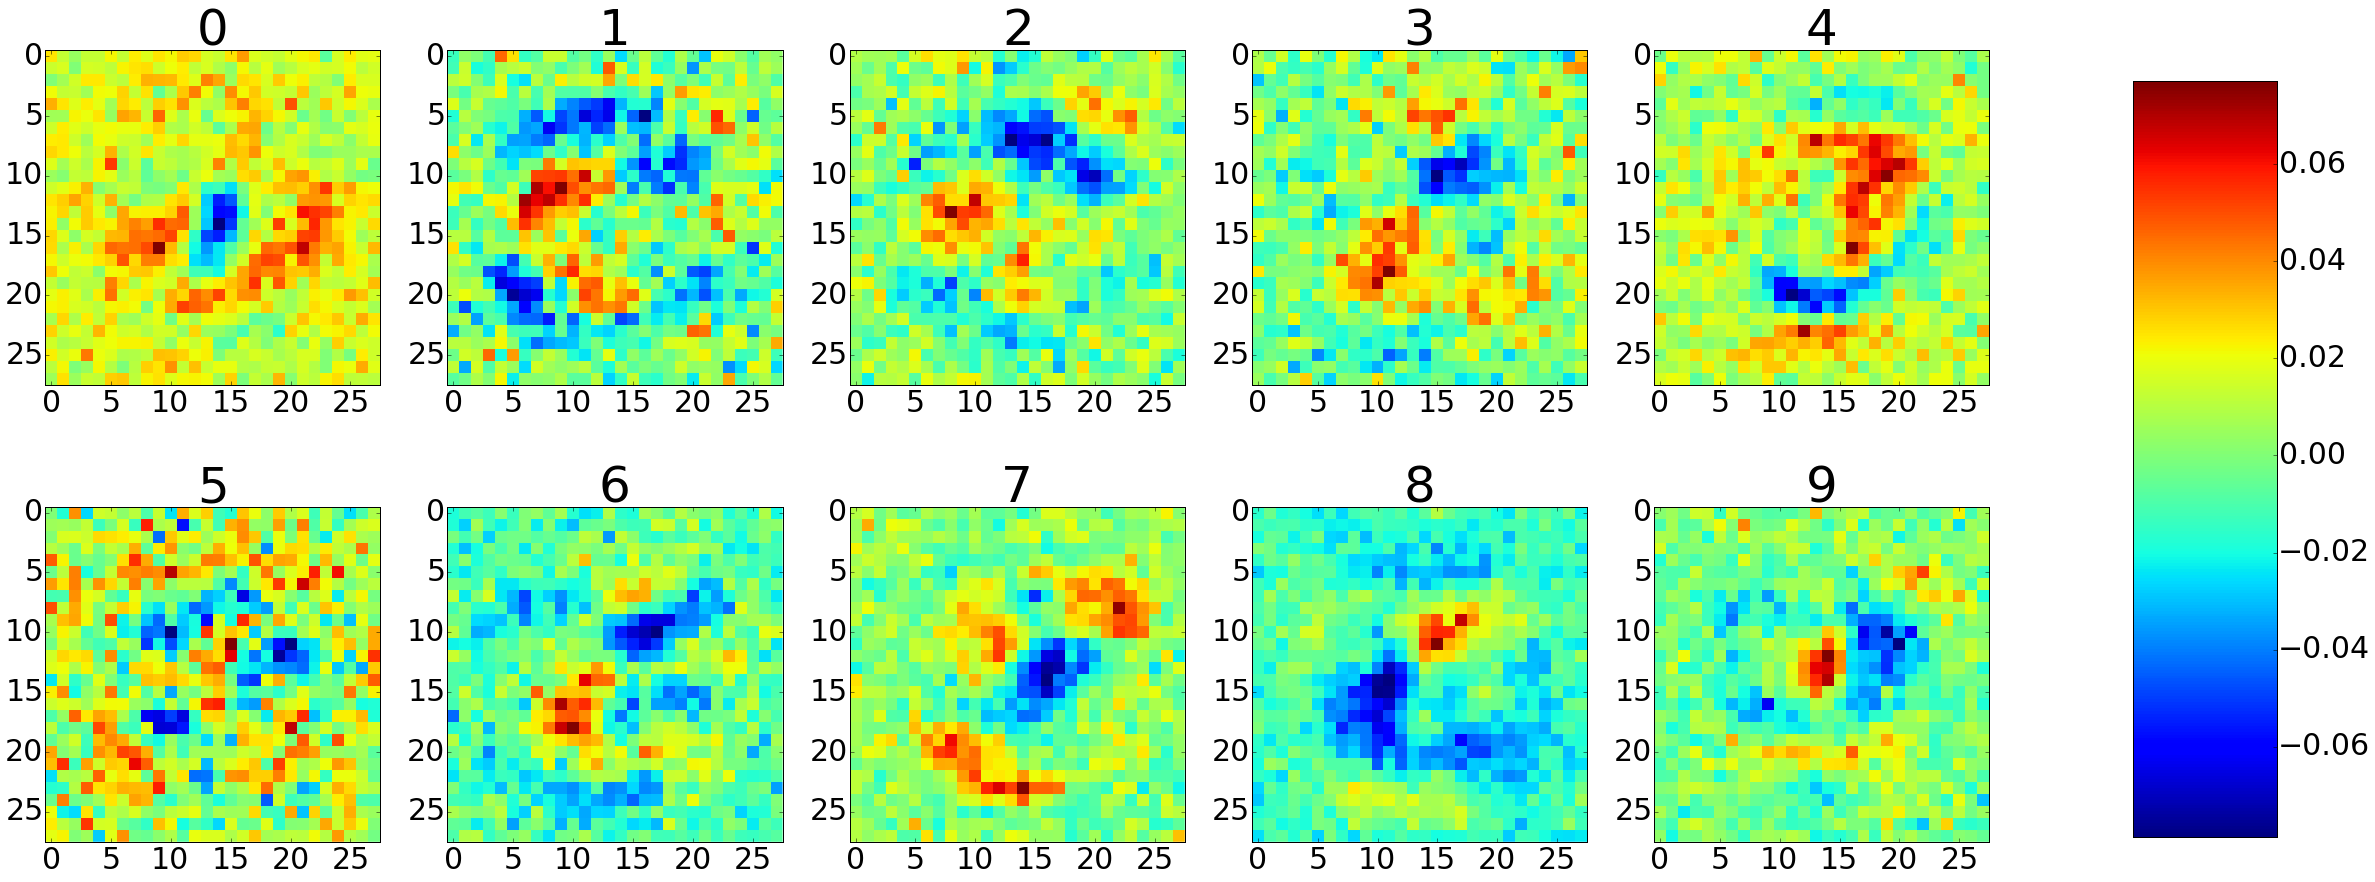

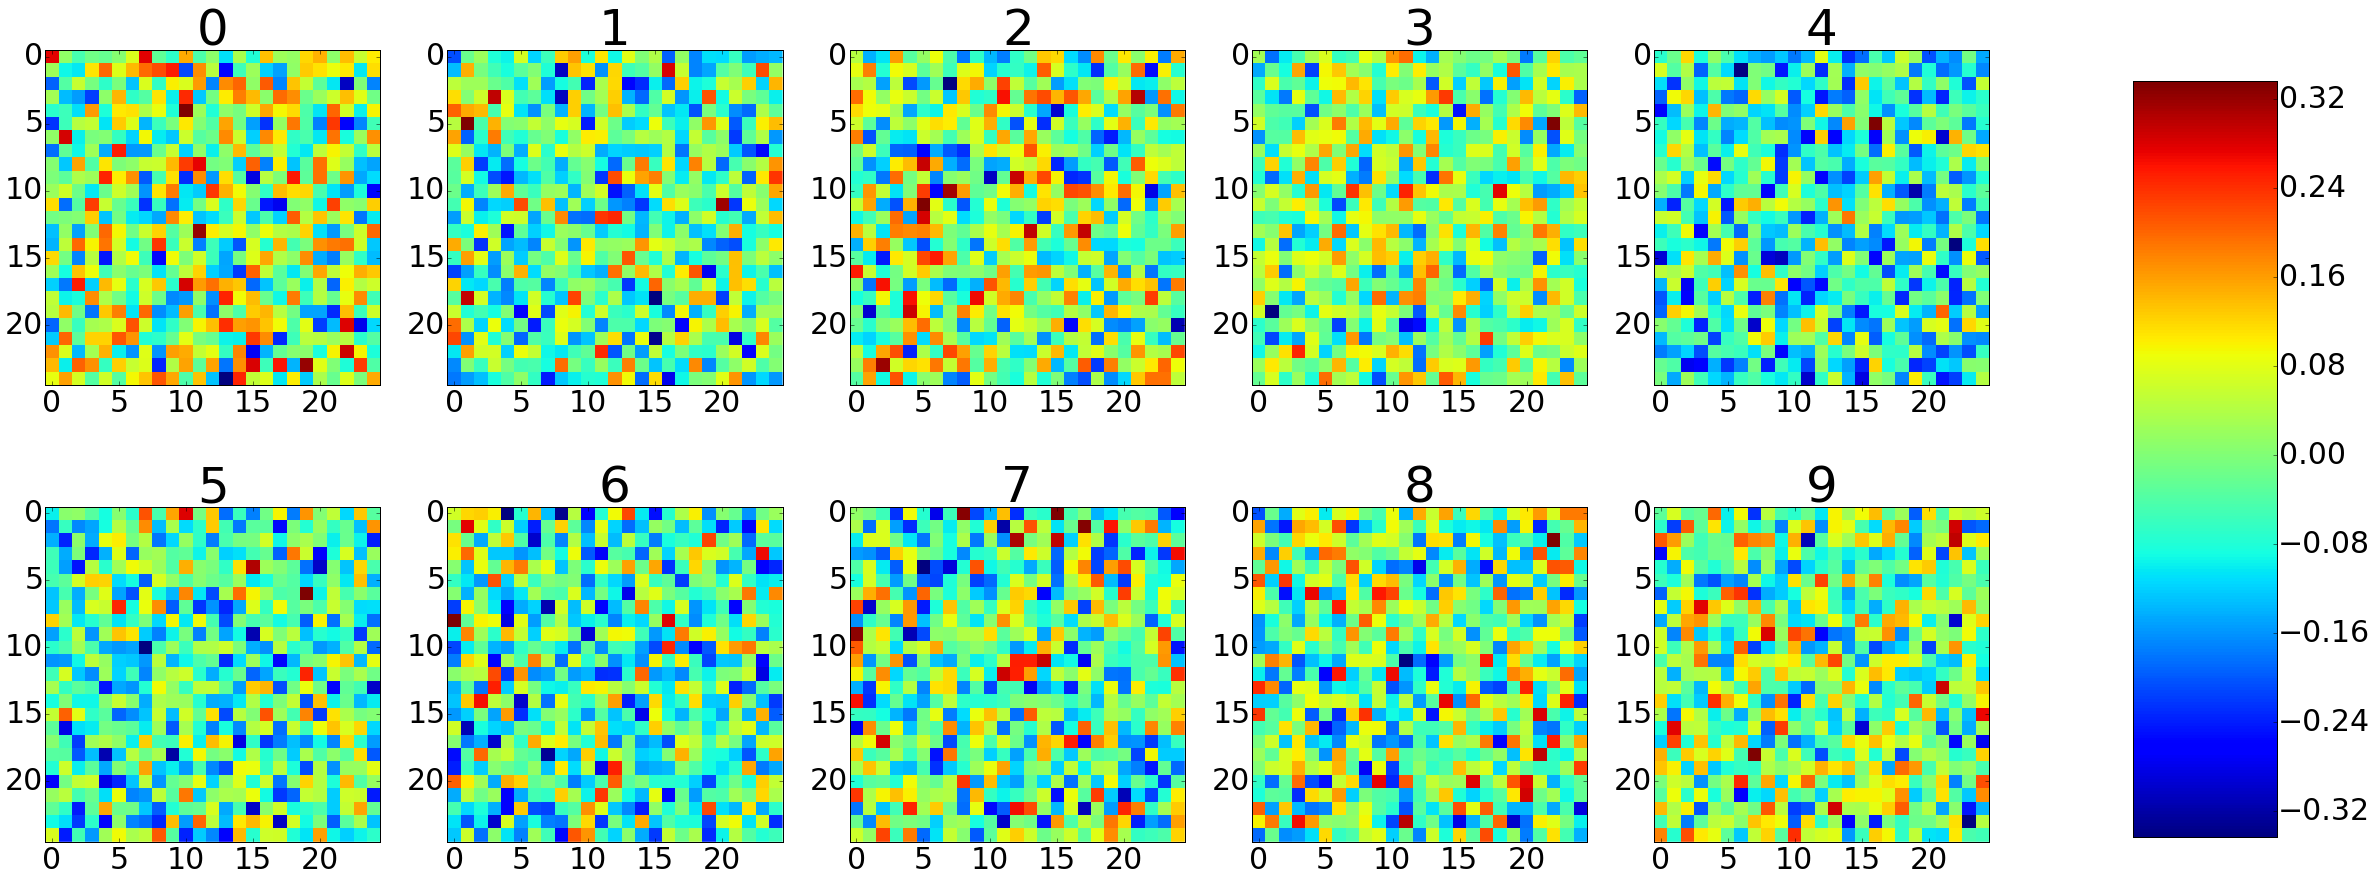

In [13]:
theano.printing.debugprint(py_x)
analyze_net(w_h, 28)
analyze_net(w_o, 25)


In [29]:
"""Modern feed forward net with 2 hiddden layers, fast update using RMSProp, 
ReLU activation function, and dropout to avoi overfitting. The architecture
as follow: 737 -> 625 -> 625 -> 10
"""
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
srng = RandomStreams()

def rectify(X):    
    return T.maximum(X, 0.)

def softmax(X):
    """numerically stable softmax"""
    e_x = T.exp(X - X.max(axis=1).dimshuffle(0, 'x'))
    return e_x / e_x.sum(axis=1).dimshuffle(0, 'x')

def RMSprop(cost, params, lr=0.001, rho=0.9, epsilon=1e-6):
    """scale the gradient"""
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        # a running average of the magnitude of the gradient
        acc = theano.shared(p.get_value() * 0.)
        acc_new = rho * acc + (1 - rho) * g ** 2
        
        # scale the gradient based on runnning average
        gradient_scaling = T.sqrt(acc_new + epsilon)
        g = g / gradient_scaling
        
        # update weights and accummulator
        updates.append((acc, acc_new))
        updates.append((p, p - lr * g))
    return updates

def dropout(X, p=0.):    
    if p > 0:
        # randomly drop values and scale rest
        retain_prob = 1 - p
        X *= srng.binomial(X.shape, p=retain_prob, dtype=theano.config.floatX)
        X /= retain_prob
    return X

def model(X, w_h, w_h2, w_o, p_drop_input, p_drop_hidden):
    X = dropout(X, p_drop_input)  # add some noise into network
    h = rectify(T.dot(X, w_h))

    h = dropout(h, p_drop_hidden)
    h2 = rectify(T.dot(h, w_h2))

    h2 = dropout(h2, p_drop_hidden)
    py_x = softmax(T.dot(h2, w_o))
    return h, h2, py_x

In [30]:
X = T.fmatrix()
Y = T.fmatrix()

w_h = init_weights((784, 625))
w_h2 = init_weights((625, 625))
w_o = init_weights((625, 10))

noise_h, noise_h2, noise_py_x = model(X, w_h, w_h2, w_o, 0.2, 0.5)
h, h2, py_x = model(X, w_h, w_h2, w_o, 0., 0.)
y_x = T.argmax(py_x, axis=1)

cost = T.mean(T.nnet.categorical_crossentropy(noise_py_x, Y))
params = [w_h, w_h2, w_o]
updates = RMSprop(cost, params, lr=0.001)

train = theano.function(inputs=[X, Y], outputs=cost, updates=updates, allow_input_downcast=True)
predict = theano.function(inputs=[X], outputs=y_x, allow_input_downcast=True)

for i in range(50):
    for start, end in zip(range(0, len(trX), 128), range(128, len(trX), 128)):
        cost = train(trX[start:end], trY[start:end])
    print i, np.mean(np.argmax(teY, axis=1) == predict(teX))

0 0.9455
1 0.9639
2 0.9722
3 0.9743
4 0.9747
5 0.9789
6 0.9791
7 0.9802
8 0.9821
9 0.9812
10 0.9806
11 0.9841
12 0.9831
13 0.9838
14 0.9835
15 0.9842
16 0.9839
17 0.9844
18 0.9834
19 0.9841
20 0.9839
21 0.9848
22 0.9845
23 0.9849
24 0.9855
25 0.9854
26 0.9855
27 0.9852
28 0.9856
29 0.9872
30 0.9861
31 0.9852
32 0.9857
33 0.9862
34 0.9867
35 0.9867
36 0.9854
37 0.9864
38 0.9865
39 0.9869
40 0.987
41 0.9863
42 0.9855
43 0.9862
44 0.9863
45 0.9864
46 0.9857
47 0.9873
48 0.9863
49 0.9871


Elemwise{true_div,no_inplace} [@A] ''   
 |Elemwise{exp,no_inplace} [@B] ''   
 | |Elemwise{sub,no_inplace} [@C] ''   
 |   |dot [@D] ''   
 |   | |Elemwise{maximum,no_inplace} [@E] ''   
 |   | | |dot [@F] ''   
 |   | | | |Elemwise{maximum,no_inplace} [@G] ''   
 |   | | | | |dot [@H] ''   
 |   | | | | | |<TensorType(float32, matrix)> [@I]
 |   | | | | | |<TensorType(float64, matrix)> [@J]
 |   | | | | |DimShuffle{x,x} [@K] ''   
 |   | | | |   |TensorConstant{0.0} [@L]
 |   | | | |<TensorType(float64, matrix)> [@M]
 |   | | |DimShuffle{x,x} [@N] ''   
 |   | |   |TensorConstant{0.0} [@L]
 |   | |<TensorType(float64, matrix)> [@O]
 |   |DimShuffle{0,x} [@P] ''   
 |     |MaxAndArgmax.0 [@Q] 'max'   
 |       |dot [@D] ''   
 |       |TensorConstant{1} [@R]
 |DimShuffle{0,x} [@S] ''   
   |Sum{axis=[1], acc_dtype=float64} [@T] ''   
     |Elemwise{exp,no_inplace} [@B] ''   


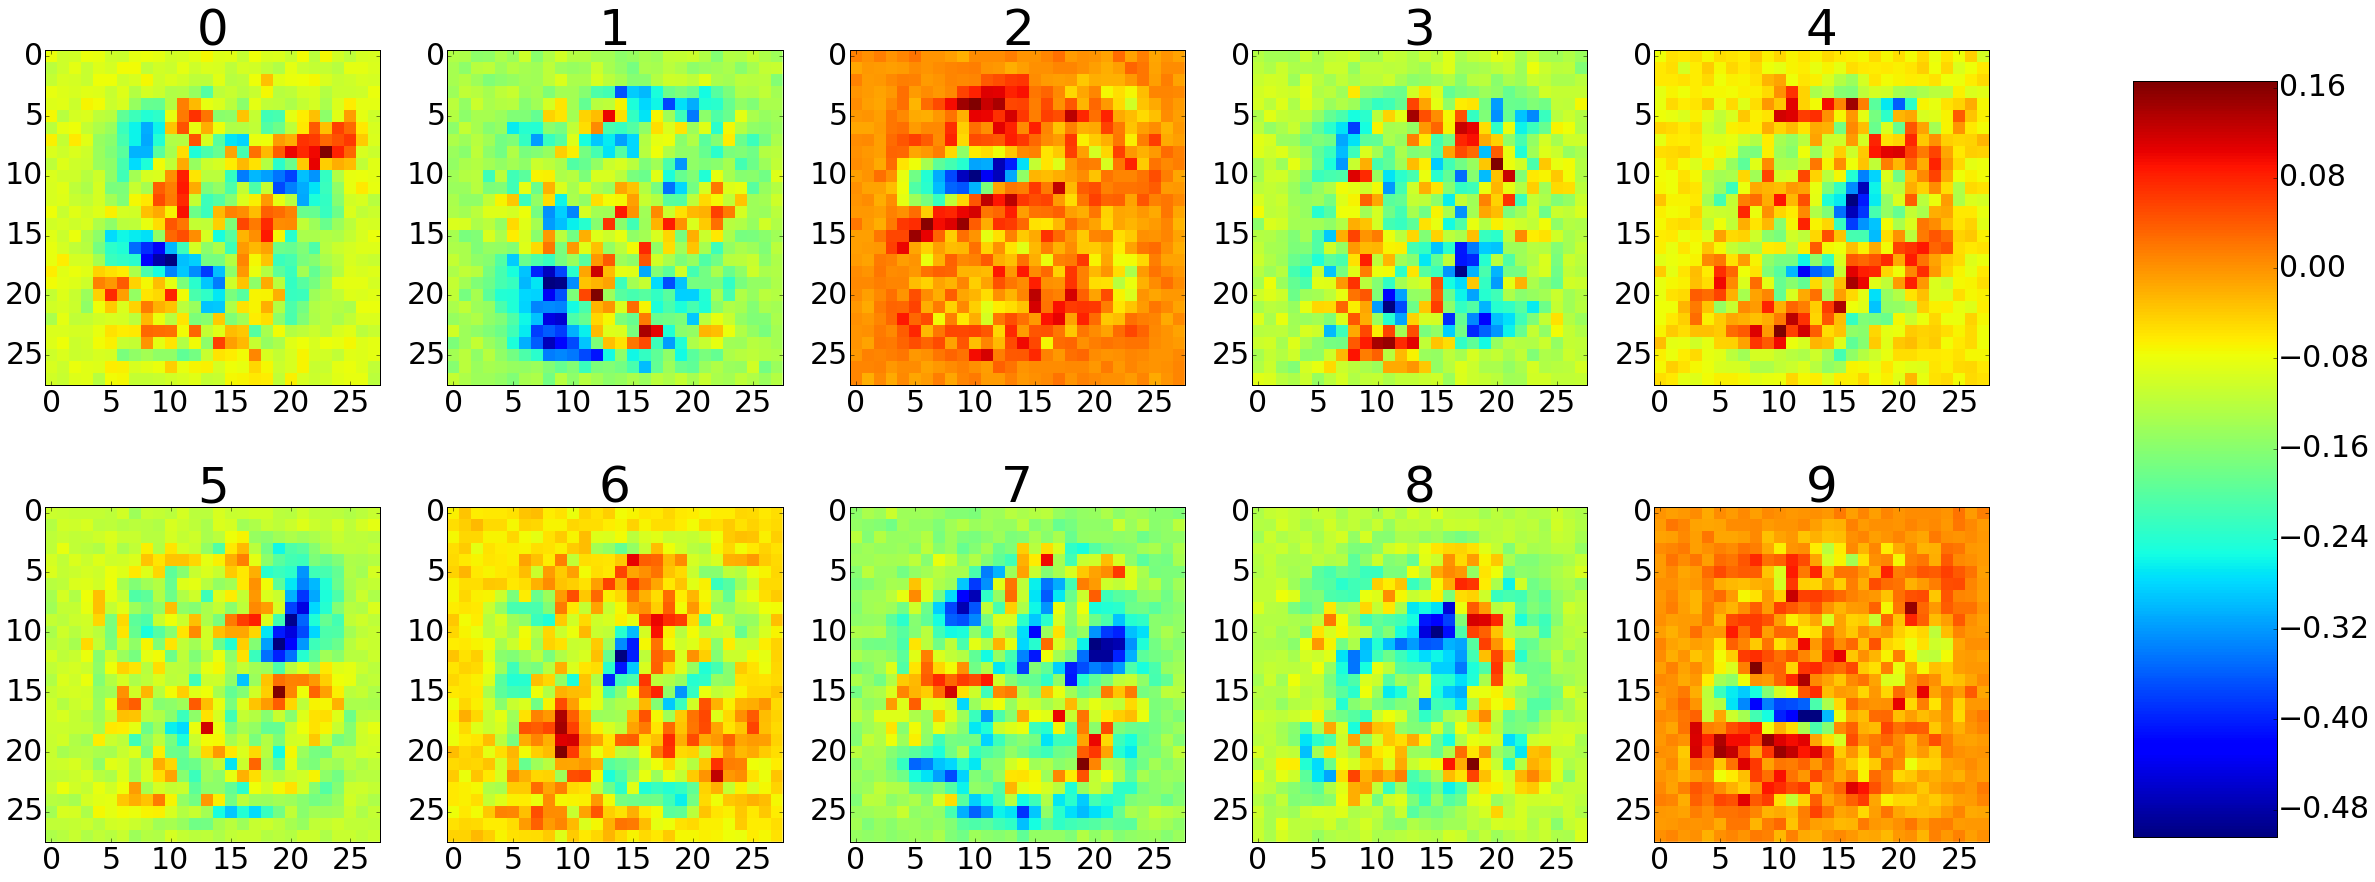

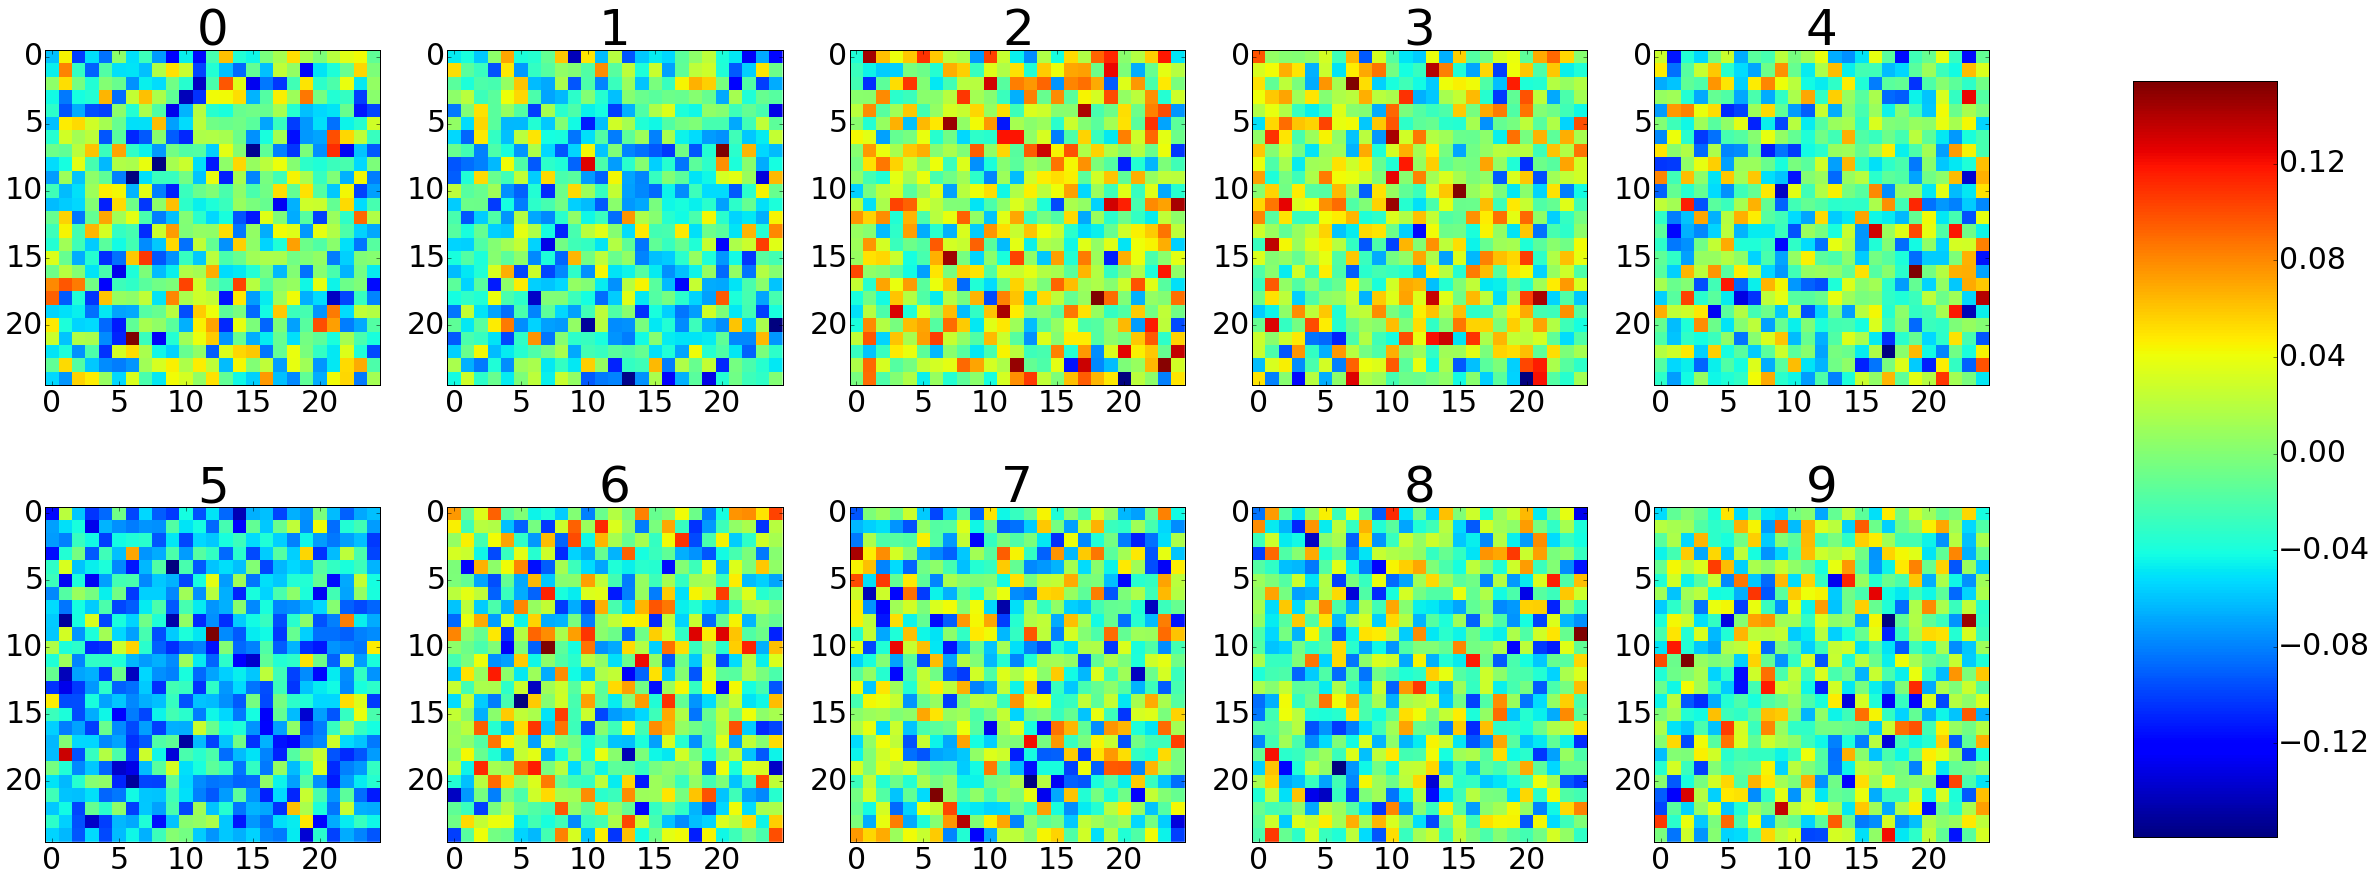

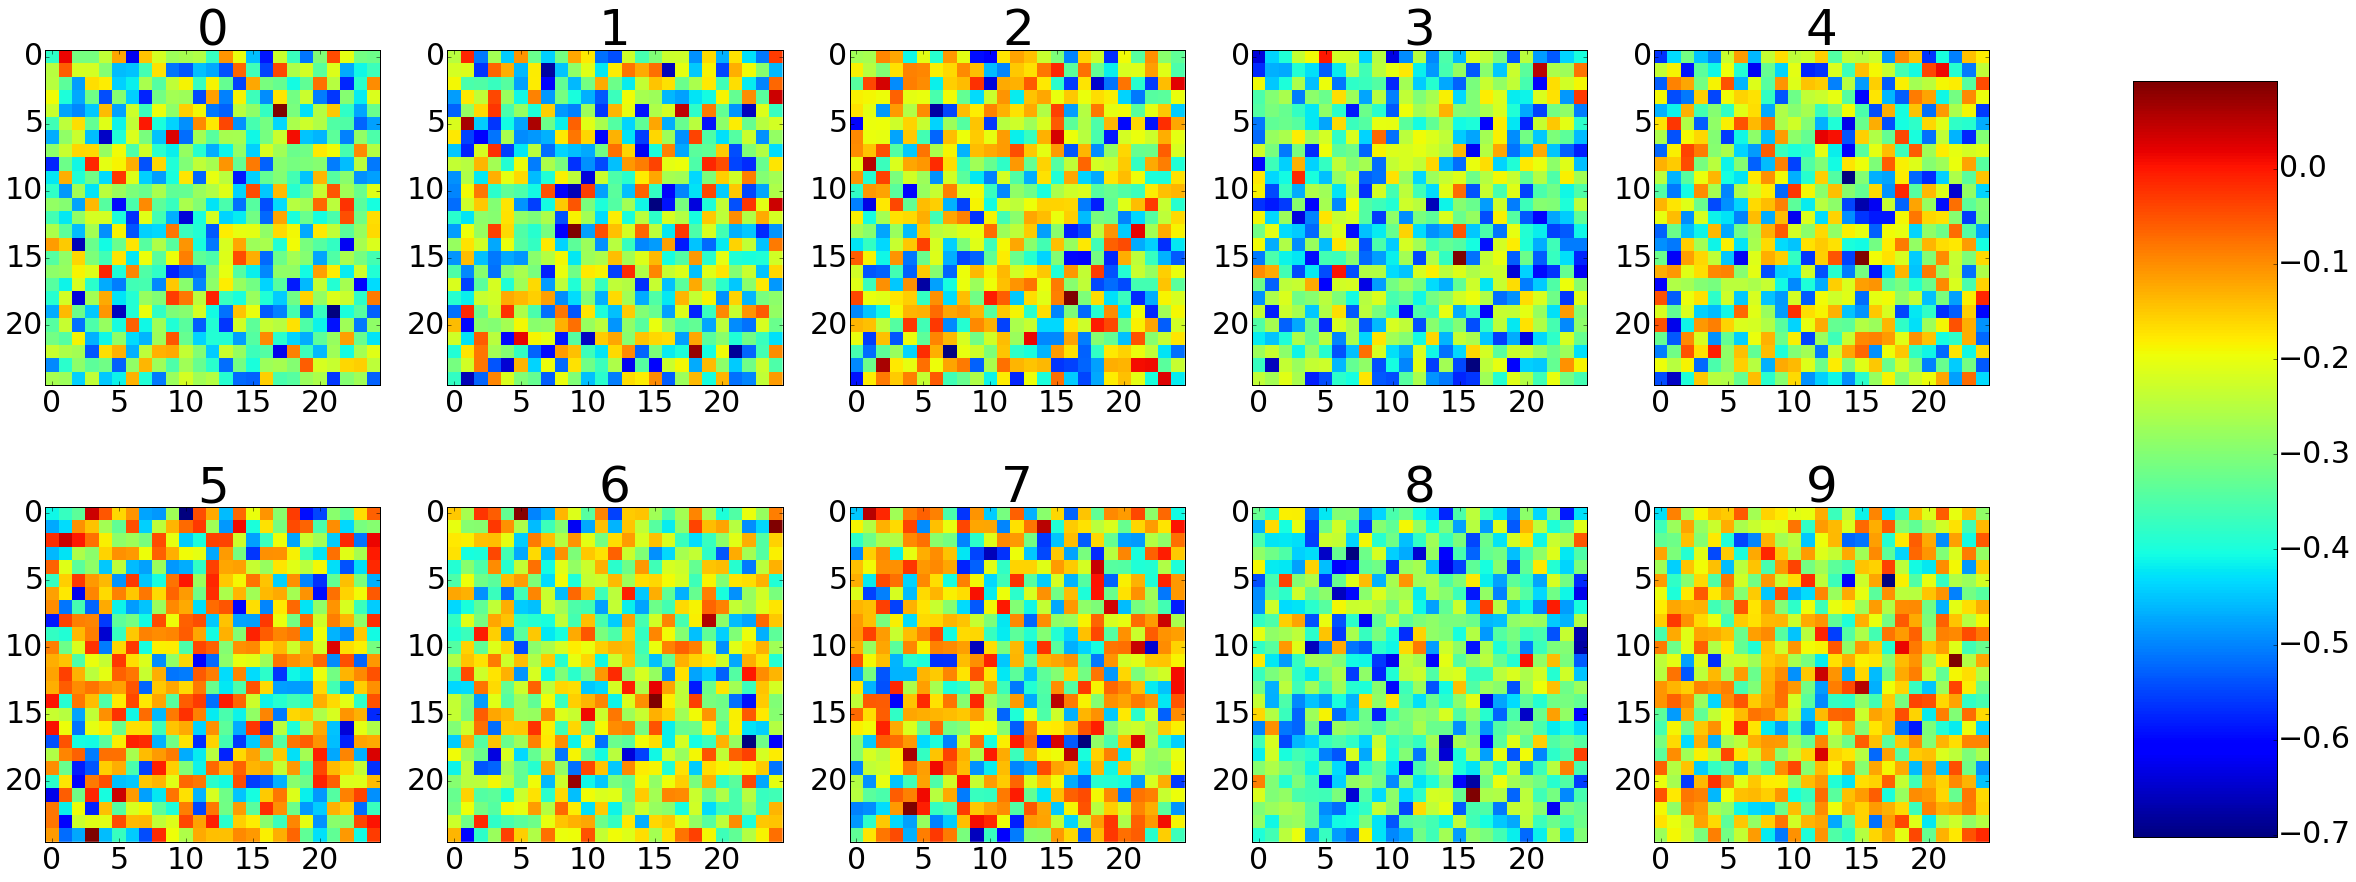

In [31]:
theano.printing.debugprint(py_x)
analyze_net(w_h, 28)
analyze_net(w_h2, 25)
analyze_net(w_o, 25)

In [32]:
"""Convolutional Neural Network"""
from theano.tensor.nnet.conv import conv2d
from theano.tensor.signal.downsample import max_pool_2d

def model(X, w, w2, w3, w4, p_drop_conv, p_drop_hidden):
    l1a = rectify(conv2d(X, w, border_mode='full'))
    l1 = max_pool_2d(l1a, (2, 2))
    l1 = dropout(l1, p_drop_conv)

    l2a = rectify(conv2d(l1, w2))
    l2 = max_pool_2d(l2a, (2, 2))
    l2 = dropout(l2, p_drop_conv)

    l3a = rectify(conv2d(l2, w3))
    l3b = max_pool_2d(l3a, (2, 2))
    l3 = T.flatten(l3b, outdim=2)
    l3 = dropout(l3, p_drop_conv)

    l4 = rectify(T.dot(l3, w4))
    l4 = dropout(l4, p_drop_hidden)

    pyx = softmax(T.dot(l4, w_o))
    return l1, l2, l3, l4, pyx

trX, teX, trY, teY = mnist(onehot=True)

trX = trX.reshape(-1, 1, 28, 28)
teX = teX.reshape(-1, 1, 28, 28)

X = T.dtensor4()
Y = T.fmatrix()

w = init_weights((32, 1, 3, 3))
w2 = init_weights((64, 32, 3, 3))
w3 = init_weights((128, 64, 3, 3))
w4 = init_weights((128 * 3 * 3, 625))
w_o = init_weights((625, 10))

noise_l1, noise_l2, noise_l3, noise_l4, noise_py_x = model(X, w, w2, w3, w4, 0.2, 0.5)
l1, l2, l3, l4, py_x = model(X, w, w2, w3, w4, 0., 0.)
y_x = T.argmax(py_x, axis=1)


cost = T.mean(T.nnet.categorical_crossentropy(noise_py_x, Y))
params = [w, w2, w3, w4, w_o]
updates = RMSprop(cost, params, lr=0.001)

train = theano.function(inputs=[X, Y], outputs=cost, updates=updates, allow_input_downcast=True)
predict = theano.function(inputs=[X], outputs=y_x, allow_input_downcast=True)

for i in range(10):
    for start, end in zip(range(0, len(trX), 128), range(128, len(trX), 128)):
        cost = train(trX[start:end], trY[start:end])
    print np.mean(np.argmax(teY, axis=1) == predict(teX))

0.9325
0.9735
0.9801
0.9886
0.9893
0.9922
0.9911
0.9906
0.9905
0.9924


NameError: name 'w' is not defined